In [63]:
import requests
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# USE NEW SITES IN NOTES

## Sites
- Long Beach-Signal Hill (33.79371	-118.17102)
- West Los Angeles-VA Hospital (34.05109	-118.45640)
- Pico Rivera-4144 San Gabriel (34.01029	-118.06850)
- Pasadena-S Wilson Avenue (34.13265	-118.12714)
- Los Angeles-North Main Street (34.06653	-118.22676)

In [101]:
start_date = '2020-01-01'
end_date = '2020-12-31'
sites = ['DTLA', 'Long_Beach', 'Pasadena', 'Pico_Rivera', 'West_LA']

data_path = '../AQMD data/Location Data'
files = [x for x in os.listdir(data_path) if not x.startswith('.')]

datelist = pd.date_range(start_date, end_date).tolist()
datelist = [date.to_pydatetime().strftime('%Y-%m-%d') for date in datelist]

data = {}

In [104]:
for f in files:
    variable = f.split('_')[-1][:-4].lower()
    site = f[:-len(variable)-5]
    
    df = pd.read_csv(f'{data_path}/{f}')
    
    df = df[['summary_date', f'{variable}_dmax1hr']]
    df = df.rename(columns={f'{variable}_dmax1hr': variable})
    df = df.dropna()

    df.index = pd.DatetimeIndex(df['summary_date'])
    df = df.drop('summary_date', axis=1)
    df = df.reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
    df[variable] = df[variable].interpolate(method="cubic")
    
    data[site] = {}
    data[site][variable] = df

In [118]:
dfs = [(site, df['ozone']) for site, df in data.items()]

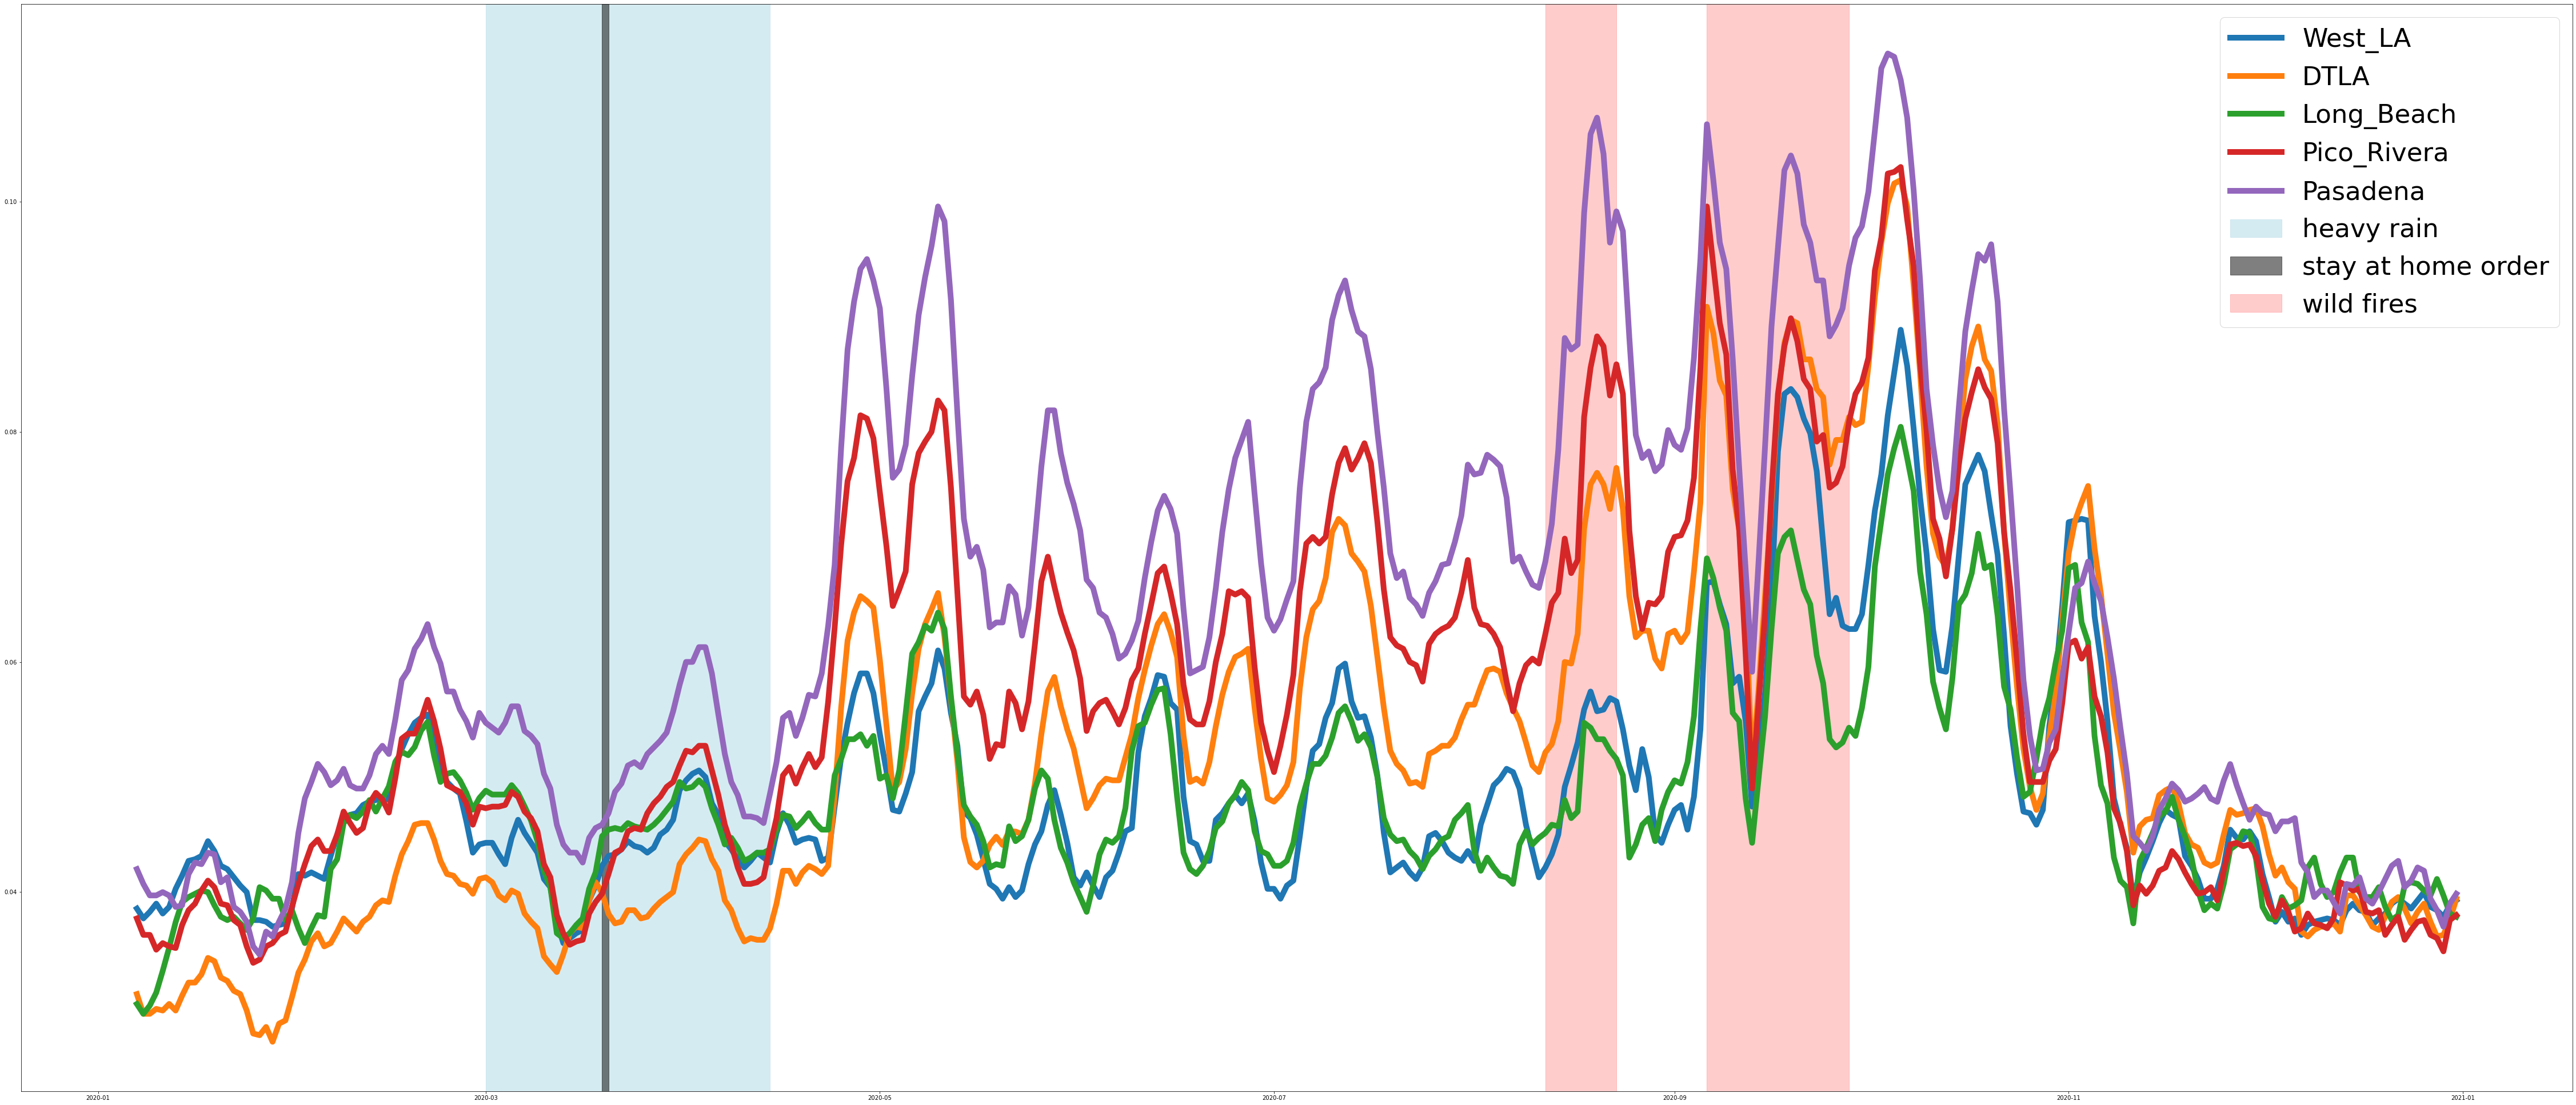

In [149]:
fig = plt.figure(figsize=(80, 35))

for df in dfs:
    plt.plot(df[1]['ozone'].rolling(7).mean(), label=df[0], lw=10)

# ax[i].fill_between(list(range(1, len(x[1])+1)), test[var].rolling(7).mean(),color='mediumseagreen', label='prev decade avg')
# Wet months
plt.axvspan('2020-03-01', '2020-04-14', alpha=0.5, color='lightblue', label='heavy rain')

# Stay at home dates
plt.axvspan('2020-03-19', '2020-03-20', alpha=0.5, color='black', label='stay at home order')

# Fire dates
# http://www.aqmd.gov/home/news-events/news-and-media/2020-news-archives
plt.axvspan('2020-08-12', '2020-08-23', alpha=0.2, color='red', label='wild fires')
plt.axvspan('2020-09-06', '2020-09-28', alpha=0.2, color='red')  

    
plt.legend(prop={'size': 45})
plt.show()